In [1]:
from core.networks.efficientnet import EfficientNet

import json

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from safetensors.torch import load_model, save_model

from data.get_data import get_cifar10
import core.utils as U
from core.device import get_device
from core.optimizers.sgd_lrd import SGD_LRD
from core.scheduler import CosineAnnealingWarmupRestarts

In [2]:
model_path = "./models"
result_path = "./results"
batch_size = 64
phi = 0
depth_factor = pow(1.2, phi)
width_factor = pow(1.1, phi)
res_factor = pow(1.15, phi)
epochs = 20
learning_rate = 0.1
optimizer_name = "SGD_LRD"
activation_fn_name = "CELU"

model_name = f"EfficientNetB{phi}-CIFAR10-{activation_fn_name}-{optimizer_name}-{learning_rate}"

device = get_device()

loss_history = []
accuracy_history = []

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

train_loader, test_loader = get_cifar10(batch_size, upscale=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


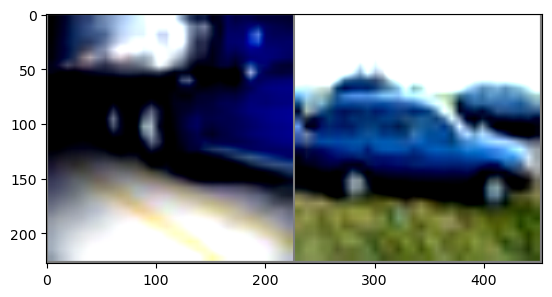

truck, car  


In [3]:
dateiter = iter(train_loader)
images, labels = next(dateiter)

max_img_grid = 2 if batch_size > 2 else batch_size

images = images[:max_img_grid]
labels = labels[:max_img_grid]

U.show_normalized_img(torchvision.utils.make_grid(images))

print(", ".join(f"{classes[labels[j]]:5s}" for j in range(max_img_grid)))

In [4]:
network = EfficientNet(num_classes=10, width_factor=width_factor, depth_factor=depth_factor)

use_pretrained_model = False

try:
    load_model(network, f"{model_path}/{model_name}.safetensors")
    use_pretrained_model = True
    print("Loaded pretrained model")
except:
    network = nn.DataParallel(network)
    print("No pretrained model found")

network.to(device)

print("Model loaded")

No pretrained model found
Model loaded


In [5]:
optimizers = {
    "sgd": opt.SGD(network.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4),
    "adamw": opt.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=False),
    "sgd_lrd": SGD_LRD(network.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4, dropout=0.5),
}

criterion = nn.CrossEntropyLoss()
optimizer = optimizers[optimizer_name.lower()]
scheduler = CosineAnnealingWarmupRestarts(optimizer, epochs/2, max_lr=learning_rate, min_lr=learning_rate/100, warmup_steps=4)

In [6]:
if not use_pretrained_model:
    for epoch in range(epochs):
        correct = 0
        total = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = outputs.max(1)
            total +=  labels.size(0)
            correct += predicted.eq(labels).sum().item()

                
        train_accuracy = correct / total * 100
        accuracy_history.append(train_accuracy)
        loss_history.append(loss.cpu().item())
        
        print(f"epoch {epoch + 1} loss: {loss:.3f}, acc: {train_accuracy:.3f}%")

        scheduler.step()
                
    save_model(network, f"{model_path}/{model_name}.safetensors")

    with open(f"{result_path}/{model_name}.txt", "w", encoding="utf-8") as f:
        a = {
            "loss": loss_history,
            "acc": accuracy_history
        }
        f.write(json.dumps(a))

    print("Train finished")
else:
    with open(f"{result_path}/{model_name}.txt", "r", encoding="utf-8") as f:
        json_file = json.load(f)
        loss_history = json_file["loss"]
        accuracy_history = json_file["acc"]

epoch 1 loss: 2.151, acc: 23.194%
epoch 2 loss: 2.137, acc: 29.460%
epoch 3 loss: 1.944, acc: 33.090%
epoch 4 loss: 2.207, acc: 39.326%
epoch 5 loss: 1.986, acc: 47.072%
epoch 6 loss: 1.986, acc: 56.496%
epoch 7 loss: 1.902, acc: 63.628%
epoch 8 loss: 1.774, acc: 70.154%
epoch 9 loss: 1.707, acc: 75.592%
epoch 10 loss: 1.808, acc: 79.728%
epoch 11 loss: 1.712, acc: 81.712%
epoch 12 loss: 1.682, acc: 78.110%
epoch 13 loss: 1.553, acc: 75.414%
epoch 14 loss: 1.744, acc: 73.664%
epoch 15 loss: 1.876, acc: 72.756%
epoch 16 loss: 1.714, acc: 74.274%
epoch 17 loss: 1.748, acc: 76.092%
epoch 18 loss: 1.657, acc: 79.112%
epoch 19 loss: 1.716, acc: 82.568%
epoch 20 loss: 1.516, acc: 85.728%
Train finished


Min train loss: 1.5159094333648682


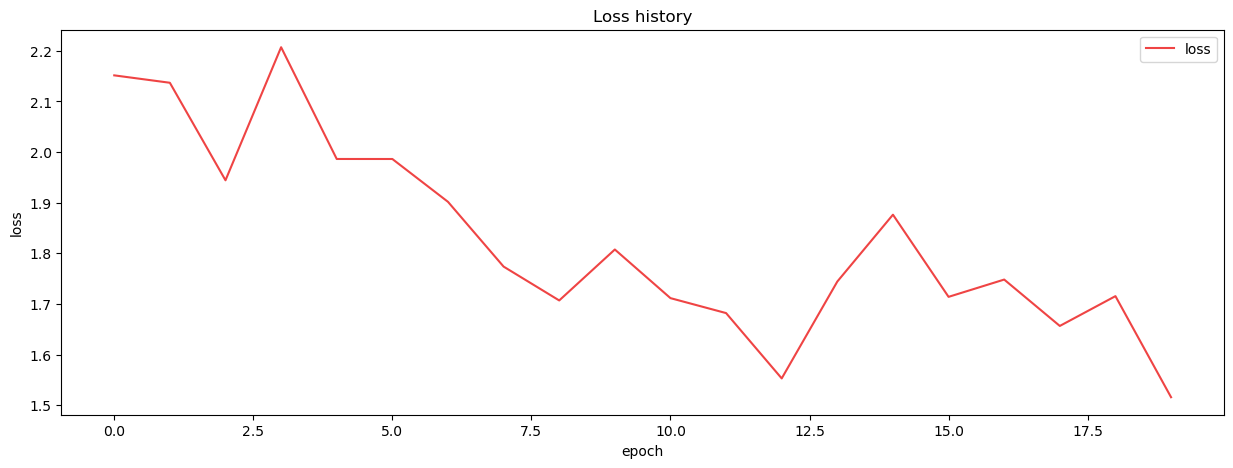

In [7]:
X = np.arange(epochs)

print(f"Min train loss: {np.min(loss_history)}")
fig = plt.gcf()
plt.plot(X, loss_history, color=U.get_color(0), label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss history")
fig.set_size_inches(15, 5)
plt.show()

Max train accuracy: 0.85728


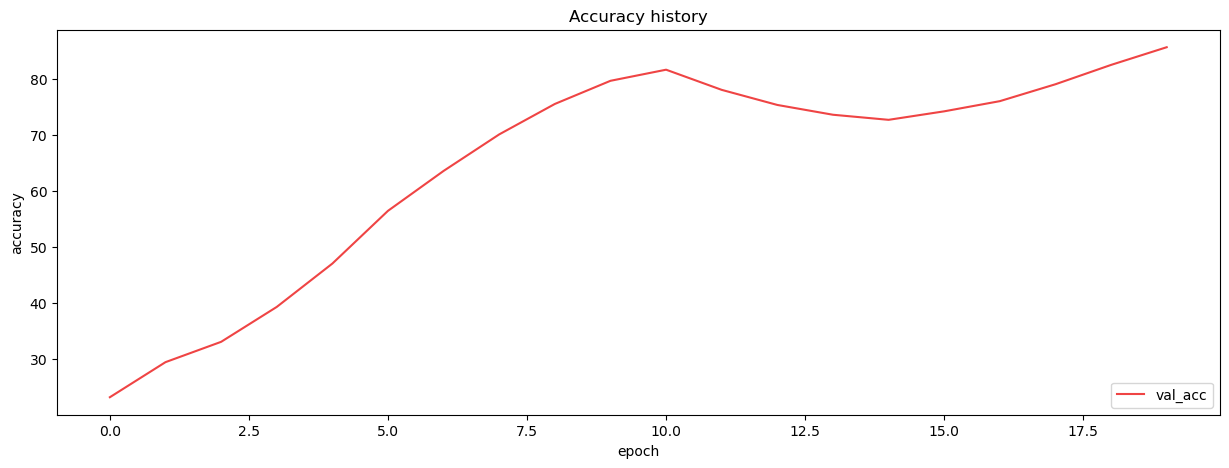

In [8]:
print(f"Max train accuracy: {np.max(accuracy_history)}%")
fig = plt.gcf()
plt.plot(X, accuracy_history, color=U.get_color(0), label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy history")
fig.set_size_inches(15, 5)
plt.show()

In [10]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
                correct += 1
                
            total_pred[classes[label]] += 1
        
        total += labels.size(0)
        
print(f"Accuracy of 10000 test images: {100 * correct / total:.1f}%")
            
for classname, corrent_count in correct_pred.items():
    train_accuracy = 100 * float(corrent_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {train_accuracy:.1f}%")

Accuracy for class: plane is 86.6%
Accuracy for class: car   is 93.7%
Accuracy for class: bird  is 78.0%
Accuracy for class: cat   is 72.7%
Accuracy for class: deer  is 83.1%
Accuracy for class: dog   is 73.4%
Accuracy for class: frog  is 85.1%
Accuracy for class: horse is 89.2%
Accuracy for class: ship  is 89.2%
Accuracy for class: truck is 91.2%
